In [14]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer, plot_confusion_matrix
from wordcloud import WordCloud

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from code.cleaner import preprocess
from code.viz import word_plot

from joblib import parallel_backend, dump, load

sns.set()

In [15]:
dill = load('./data/best_estimator.pkl')

In [16]:
sentiments = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')
sentiments.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [18]:
sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

sentiments['sentiment'] = sentiments['sentiment'].replace("No emotion toward brand or product", "Neutral")

In [19]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [20]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

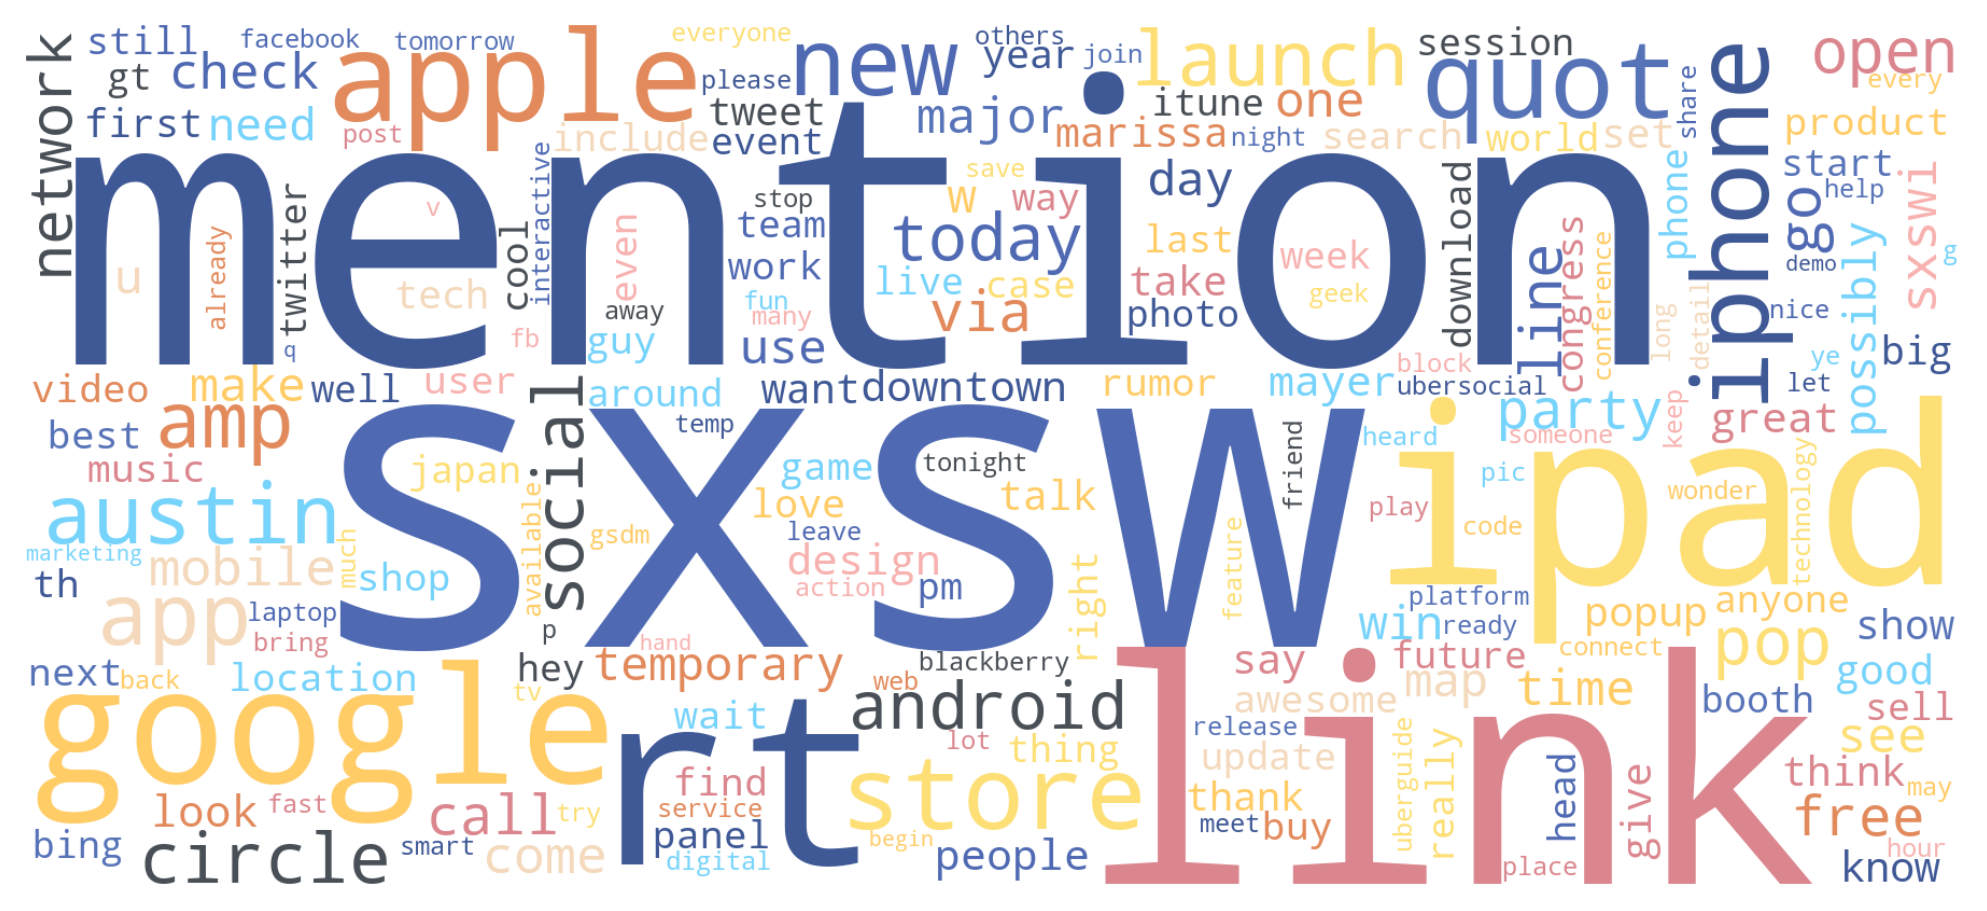

In [61]:
from matplotlib.colors import ListedColormap
cloud = sentiments.copy()

cloud['tokenized'], cloud['tokens'] = \
    preprocess(cloud['tweet_text'], ret_tokens=True)

cloud['tokens_str'] = [' '.join(token_list) for token_list in cloud['tokens']]

canvamap = ListedColormap(['#3f5896', '#494f56', '#4f6ab3', '#5773b8', '#76d3fb',
                          '#db868e', '#e28a5c', '#f4d9bc', '#f7b2b0', '#fddf75', '#ffcc66'])

wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='#ffffff'
).generate(" ".join(cloud['tokens_str']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [55]:
result = (
    pd.Series(cloud['tokens']
                .explode()
                .astype(str))
)

result.to_csv("./data/wordcloud.csv", index=False, header=None)

In [52]:
result.values

['@wesley' 'g' 'iphone' ... 'offer' '#sxsw' 'link']


In [10]:
sw = stopwords.words('english')
#specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = ['apple', 'google', 'ipad', 'iphone', 'new', 
                    'quot', 'rt', 'store', 'app', 'get', 'launch', 
                    'austin']
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [68]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

In [69]:
canvamap = ['#3f5896', '#494f56', '#4f6ab3', '#5773b8', '#76d3fb',
                          '#db868e', '#e28a5c', '#f4d9bc', '#f7b2b0', '#fddf75', '#ffcc66']

Index([], dtype='object')


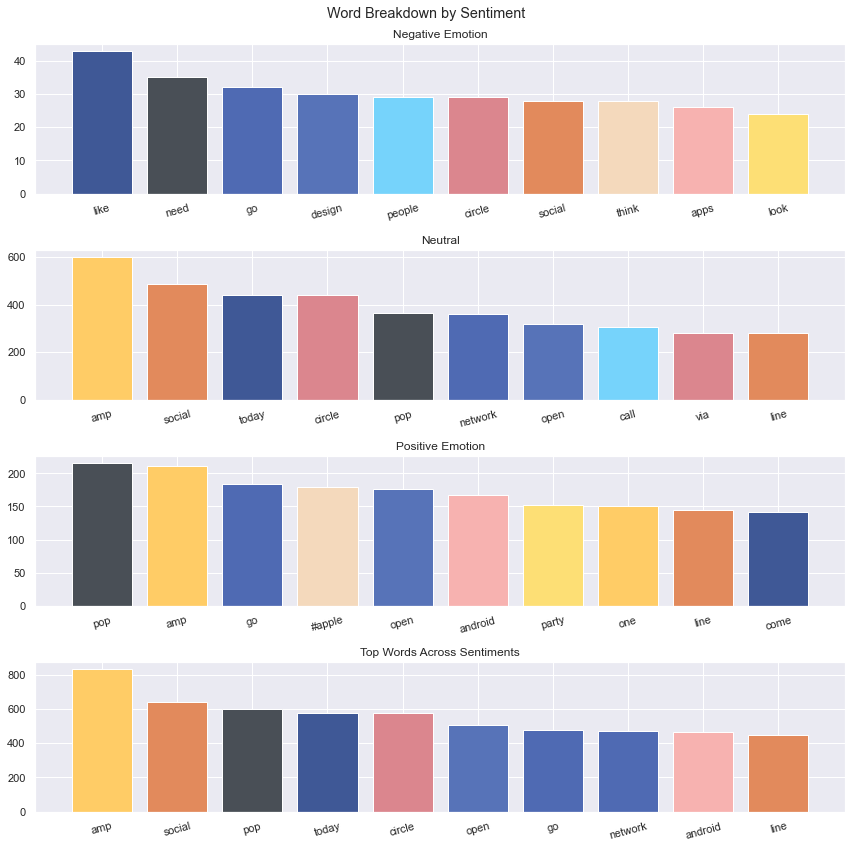

In [70]:
freq_words = word_plot(sentiments, 'sentiment', 'tokens',
    n_words=10, theme=canvamap)
print(freq_words[1])

In [72]:
X = sentiments['tokenized']
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

In [73]:
vectorizer = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)

vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.4, min_df=20, ngram_range=[1, 3])

In [74]:
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [75]:
svec = imbPipeline(steps=[
    ('sm', SMOTE(random_state=13)),
    ('svec', SVC(random_state=13))
])

svec.fit(X_train_vectorized, y_train)

Pipeline(steps=[('sm', SMOTE(random_state=13)), ('svec', SVC(random_state=13))])

In [76]:
preds = svec.predict(X_train_vectorized)
f1_score(y_train, preds, average=None)

array([0.83783784, 0.91295216, 0.85970149])

In [77]:
preds = svec.predict(X_test_vectorized)
f1_score(y_test, preds, average=None)

array([0.40196078, 0.75468332, 0.58584071])

[matplot-lib-fonts](https://jonathansoma.com/lede/data-studio/matplotlib/list-all-fonts-available-in-matplotlib-plus-samples/)

In [ ]:
cross_val_score(svec, X_train_vectorized, y_train, scoring='f1_weighted').mean()

In [ ]:
pred = ovr_svec.predict(X_train_vectorized)
f1_score(y_train, pred, average=None)

In [ ]:
rc_est = preprocess(reclassify['tweet_text'],sw)# test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)rc_tfidf = tfidf.transform(rc_est)rc_vec = pd.DataFrame(rc_tfidf.toarray(),columns=tfidf.get_feature_names())reclassify['predicted_sentiment'] = best_testimator.predict(rc_vec)

### Fitting a Naive Bayes Model

$$
\begin{bmatrix}
 & \text{Negative} & \text{Neutral} & \text{Positive} \\
\text{Negative} & \text{True-Neg} & \text{FNeu-Neg} & \text{FP-Neg} \\
\text{Neutral} & \text{False-Neg-Neu} & \text{True-Neu} & \text{False-P-Neu} \\
\text{Positive} & \text{False-Neg} & \text{False-Neu-Pos} & \text{TP} \\
\end{bmatrix}
$$

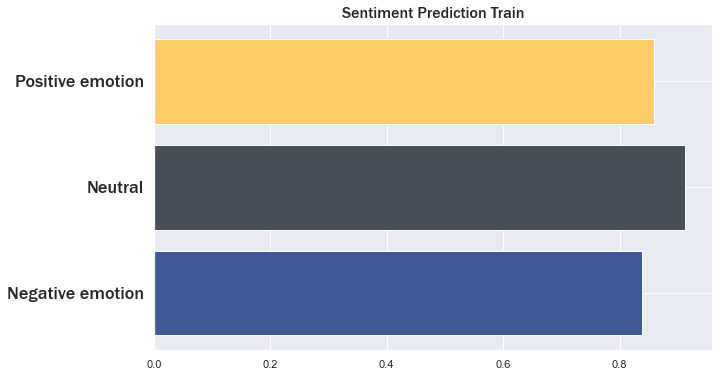

In [78]:
preds = best_model.predict(train_vec)

f1_scores = f1_score(train['sentiment'], preds, average=None)

sentiment_categories = sorted(np.unique(train['sentiment']))

colors = ['#3f5896', '#494f56', '#ffcc66']

plt.figure(figsize=(10, 6))
plt.barh(sentiment_categories, f1_scores, color=colors, )
#plt.xlabel('F1 Score', fontsize=14)
plt.title('Sentiment Training f1-scores', fontsize=16, fontname='Franklin Gothic Medium')
#plt.xticks(fontsize=12, fontname='Franklin Gothic Medium')
plt.yticks(fontsize=18, fontname='Franklin Gothic Medium')
plt.show()

In [ ]:
preds = best_model.predict(test_vec)

f1_scores = f1_score(test['sentiment'], preds, average=None)

sentiment_categories = sorted(np.unique(test['sentiment']))

colors = ['#3f5896', '#494f56', '#ffcc66']

plt.figure(figsize=(10, 6))
plt.barh(sentiment_categories, f1_scores, color=colors, )
#plt.xlabel('F1 Score', fontsize=14)
plt.title('Sentiment Test f1-scores', fontsize=16, fontname='Franklin Gothic Medium')
#plt.xticks(fontsize=12, fontname='Franklin Gothic Medium')
plt.yticks(fontsize=18, fontname='Franklin Gothic Medium')
plt.show()

In [ ]:
canvamap = ['#3f5896', '#494f56', '#4f6ab3',
            '#5773b8', '#76d3fb', '#db868e',
            '#e28a5c', '#f4d9bc', '#f7b2b0',
            '#fddf75', '#ffcc66'
           ]

fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(best_model, test_vec, test['sentiment'], ax=ax, cmap=canvamap);

____

# Project Goals

Create a model that can classify tweet sentiment in order to identify product concerns.

How do we determine sentiment?

Categorize: 
Category word frequency
Minimize shared words

Understand:
Remove meaningless words

Predict:
Use classification algorithms and hyperameter tuning to 
